# Additional Tennessee Eastman Process Simulation Data for Anomaly Detection Evaluation 

### Description

This dataverse contains the data referenced in Rieth et al. (2017). Issues and Advances in Anomaly Detection Evaluation for Joint Human-Automated Systems. To be presented at Applied Human Factors and Ergonomics 2017.

Each .RData file is an external representation of an R dataframe that can be read into an R environment with the 'load' function. The variables loaded are named ‘fault_free_training’, ‘fault_free_testing’, ‘faulty_testing’, and ‘faulty_training’, corresponding to the RData files.

Each dataframe contains 55 columns:

Column 1 ('faultNumber') ranges from 1 to 20 in the “Faulty” datasets and represents the fault type in the TEP. The “FaultFree” datasets only contain fault 0 (i.e. normal operating conditions).

Column 2 ('simulationRun') ranges from 1 to 500 and represents a different random number generator state from which a full TEP dataset was generated (Note: the actual seeds used to generate training and testing datasets were non-overlapping).

Column 3 ('sample') ranges either from 1 to 500 (“Training” datasets) or 1 to 960 (“Testing” datasets). The TEP variables (columns 4 to 55) were sampled every 3 minutes for a total duration of 25 hours and 48 hours respectively. Note that the faults were introduced 1 and 8 hours into the Faulty Training and Faulty Testing datasets, respectively.

Columns 4 to 55 contain the process variables; the column names retain the original variable names. 

In [ ]:
#importing all the necessary libraries 
import pandas as pd
import seaborn as sns
import numpy as np
import pyreadr as py # library to read .Rdata files in python
import sqlite3
import os
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer,one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape,BatchNormalization
from keras.models import Sequential
from keras import Model,Input
from keras.layers.convolutional import Conv2D,Conv1D
import keras.backend as k
from sklearn.metrics import roc_auc_score,f1_score
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping
from time import time
from scipy.sparse import hstack
from tensorflow.python.keras.callbacks import TensorBoard
import pickle
import datetime
from keras.utils import to_categorical
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

In [2]:
#reading train data in .R format
a1 = py.read_r("TEP_FaultFree_Training.RData")
a2 = py.read_r("TEP_Faulty_Training.RData")

#reading test data in .R format

a3 = py.read_r("TEP_FaultFree_Testing.RData")
a4 = py.read_r("TEP_Faulty_Testing.RData")

In [3]:
print("Objects that are present in a1 :",a1.keys())
print("Objects that are present in a2 :",a2.keys())
print("Objects that are present in a3 :",a3.keys())
print("Objects that are present in a4 :",a4.keys())

Objects that are present in a1 : odict_keys(['fault_free_training'])
Objects that are present in a2 : odict_keys(['faulty_training'])
Objects that are present in a3 : odict_keys(['fault_free_testing'])
Objects that are present in a4 : odict_keys(['faulty_testing'])


In [4]:
#REading the .Rdata files in pandas dataframe and saving it in .csv file
#reading train data
b1 = a1['fault_free_training']
b2 = a2['faulty_training']
#reading test data
b3 = a3['fault_free_testing']
b4 = a4['faulty_testing']

In [5]:
# concatinating the train and the test dataset
frames_tr = [b1,b2]
train_ts = pd.concat(frames_tr)
frames_ts = [b3,b4]
test = pd.concat(frames_ts)

In [6]:
print('Shape of the Train dataset:', train_ts.shape)
print("Shape of the Test dataset:", test.shape)

Shape of the Train dataset: (5250000, 55)
Shape of the Test dataset: (10080000, 55)


In [7]:
print("Distrubution of faults in train dataset:")
print(train_ts['faultNumber'].value_counts())

Distrubution of faults in train dataset:
1.0     250000
10.0    250000
2.0     250000
3.0     250000
4.0     250000
5.0     250000
6.0     250000
7.0     250000
8.0     250000
9.0     250000
11.0    250000
20.0    250000
12.0    250000
13.0    250000
14.0    250000
15.0    250000
16.0    250000
17.0    250000
18.0    250000
19.0    250000
0.0     250000
Name: faultNumber, dtype: int64


In [8]:
print("Distrubution of faults in train dataset:")
print(test['faultNumber'].value_counts())

Distrubution of faults in train dataset:
20    480000
9     480000
1     480000
2     480000
3     480000
4     480000
5     480000
6     480000
7     480000
8     480000
10    480000
19    480000
11    480000
12    480000
13    480000
14    480000
15    480000
16    480000
17    480000
18    480000
0     480000
Name: faultNumber, dtype: int64


# Observation:

- Both the train and test are balanced. 
- Total number of class labels are 21, with class label 0 as normal and remaining 20 class labels are the different faults.

# EDA of Train Dataset

In [10]:
train_ts.describe()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
count,5.250000e+06,5.250000e+06,5.250000e+06,5.250000e+06,5.250000e+06,5.250000e+06,5.250000e+06,5.250000e+06,5.250000e+06,5.250000e+06,...,5.250000e+06,5.250000e+06,5.250000e+06,5.250000e+06,5.250000e+06,5.250000e+06,5.250000e+06,5.250000e+06,5.250000e+06,5.250000e+06
mean,1.000000e+01,2.505000e+02,2.505000e+02,2.608409e-01,3.663777e+03,4.506178e+03,9.369238e+00,2.690159e+01,4.236293e+01,2.722150e+03,...,5.430117e+01,3.015595e+01,6.315545e+01,2.291970e+01,3.992928e+01,3.807390e+01,4.644203e+01,5.047991e+01,4.190826e+01,1.880923e+01
std,6.055301e+00,1.443373e+02,1.443373e+02,1.461083e-01,4.277760e+01,1.086998e+02,3.563536e-01,2.310677e-01,3.132701e-01,7.427919e+01,...,5.132918e+00,2.003898e+01,7.238756e+00,1.081725e+01,1.262621e+01,2.949913e+00,2.358218e+00,1.719376e+01,9.773339e+00,5.064388e+00
min,0.000000e+00,1.000000e+00,1.000000e+00,-4.735000e-03,3.327400e+03,3.540700e+03,6.639900e+00,2.538600e+01,3.965600e+01,2.413800e+03,...,3.118400e+01,-2.718600e-01,-4.893100e-03,-9.941000e-02,0.000000e+00,2.280100e+01,3.492300e+01,-3.635500e-01,-2.809500e-01,-5.327000e-03
25%,5.000000e+00,1.257500e+02,1.257500e+02,2.191800e-01,3.636800e+03,4.470000e+03,9.266000e+00,2.676000e+01,4.218200e+01,2.697800e+03,...,5.350800e+01,2.230300e+01,6.032300e+01,2.146100e+01,3.836600e+01,3.605000e+01,4.488100e+01,4.554300e+01,4.058800e+01,1.714200e+01
50%,1.000000e+01,2.505000e+02,2.505000e+02,2.510900e-01,3.663300e+03,4.508500e+03,9.354600e+00,2.690100e+01,4.234800e+01,2.705600e+03,...,5.397000e+01,2.517600e+01,6.148600e+01,2.213500e+01,3.997300e+01,3.814700e+01,4.634900e+01,4.804800e+01,4.119800e+01,1.828500e+01
75%,1.500000e+01,3.752500e+02,3.752500e+02,2.823600e-01,3.690100e+03,4.547100e+03,9.452500e+00,2.704300e+01,4.252200e+01,2.714500e+03,...,5.443200e+01,2.862500e+01,6.279000e+01,2.272400e+01,4.147700e+01,3.999700e+01,4.803700e+01,5.166200e+01,4.190600e+01,1.951200e+01
max,2.000000e+01,5.000000e+02,5.000000e+02,1.017500e+00,3.906700e+03,5.175800e+03,1.224000e+01,2.848600e+01,4.465300e+01,3.000500e+03,...,1.000000e+02,1.001900e+02,1.000200e+02,1.001100e+02,9.752800e+01,5.312100e+01,5.998000e+01,1.005200e+02,1.003200e+02,1.000100e+02


# Checking for Nan values

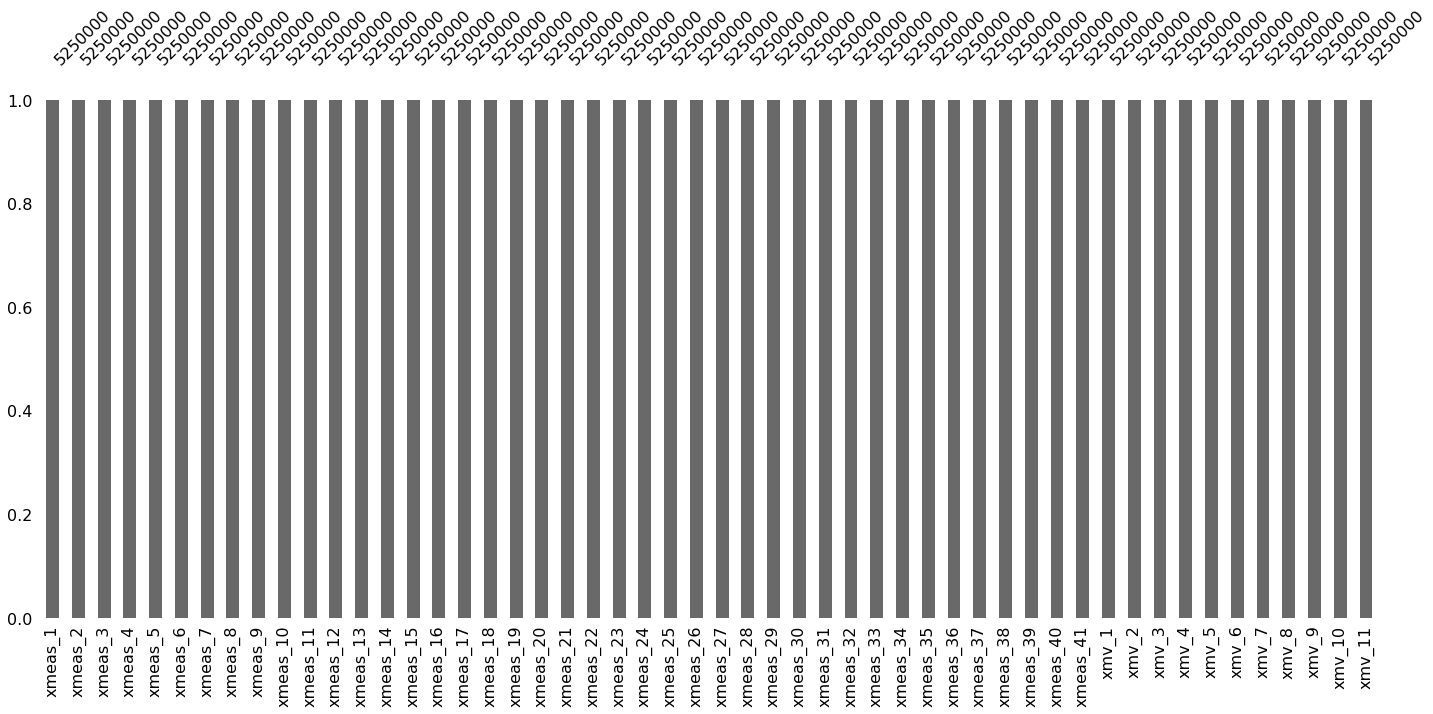

In [14]:
# Plot to indicate the number of missing values in each column of the dataset.
columns_names = train_ts.columns
msno.bar(train_ts[columns_names[3:55]])


# Observation:

- There are no Nan values in the train dataset

# Distrubution of all the 52 features in the train dataset

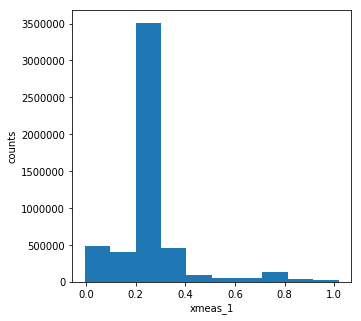

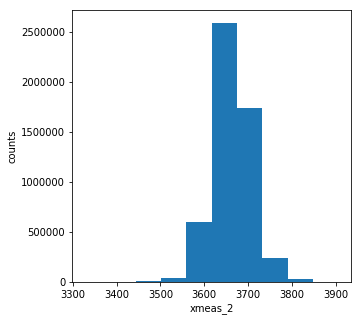

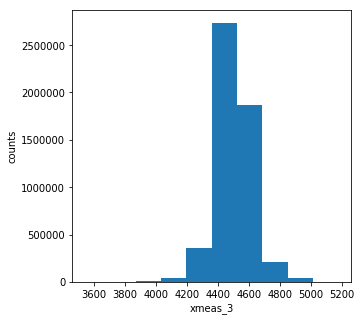

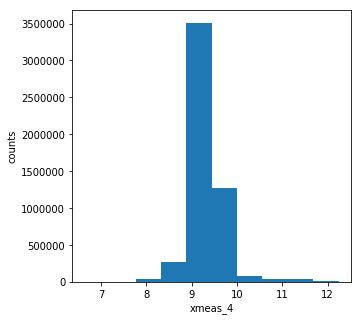

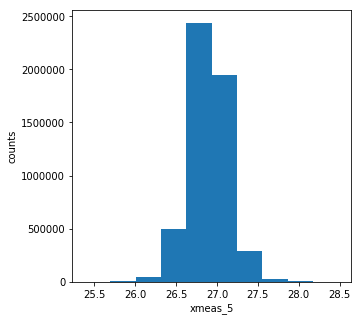

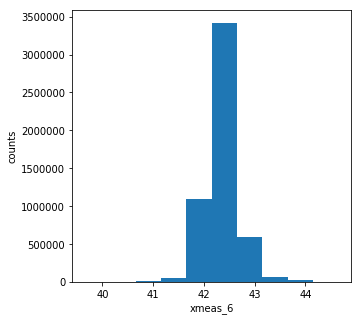

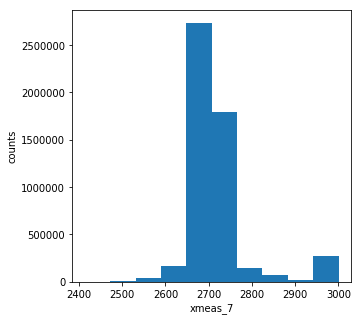

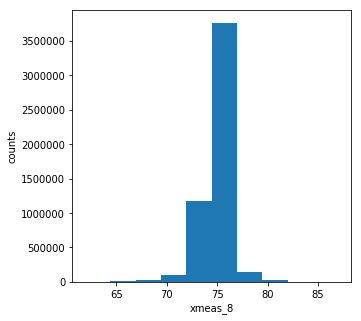

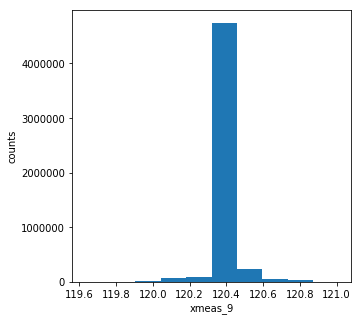

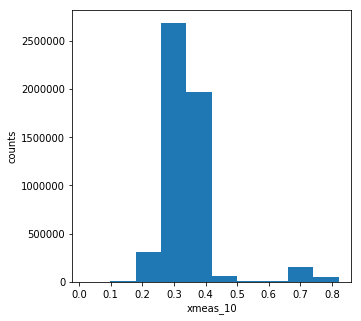

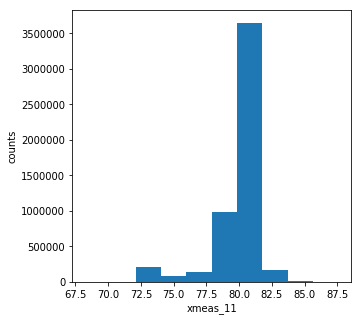

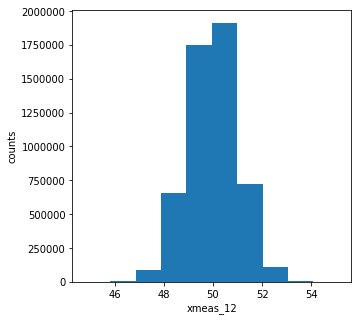

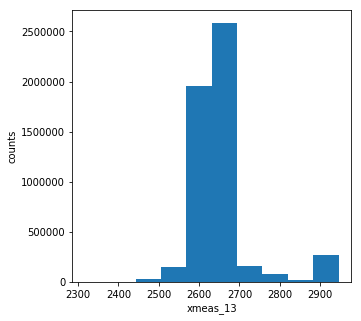

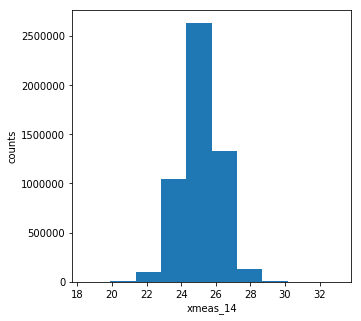

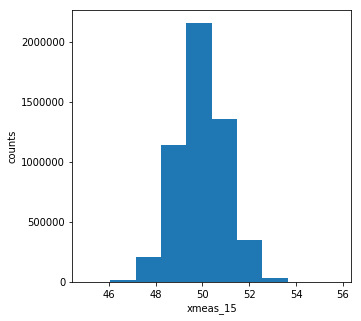

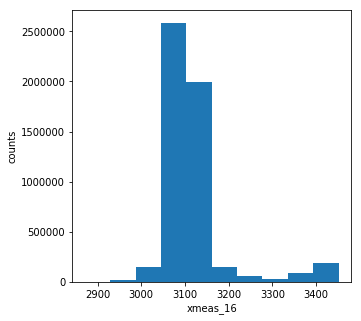

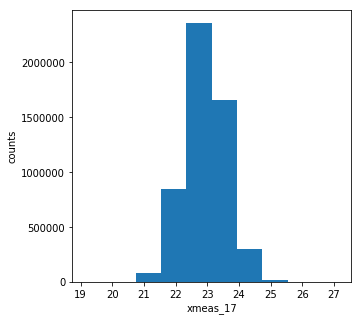

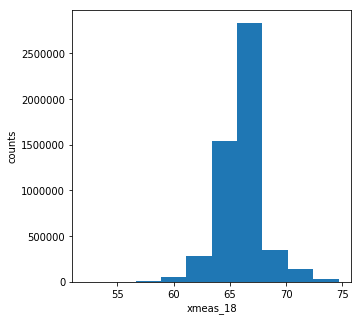

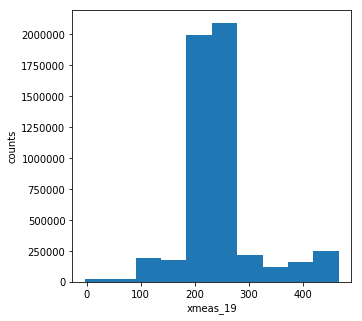

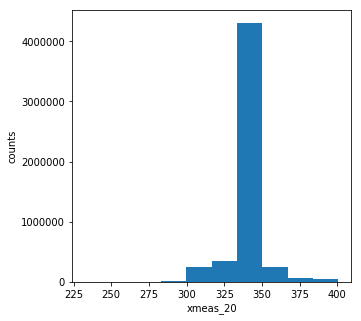

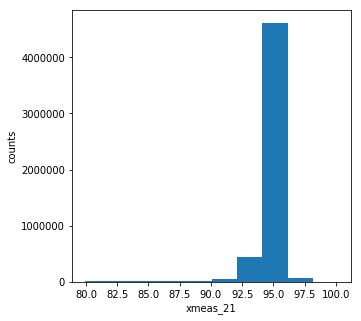

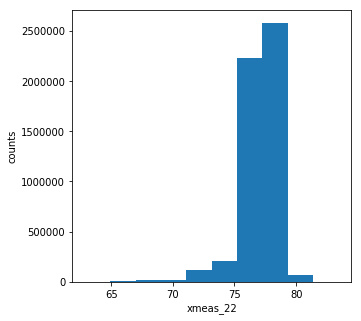

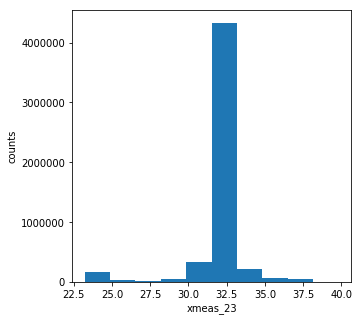

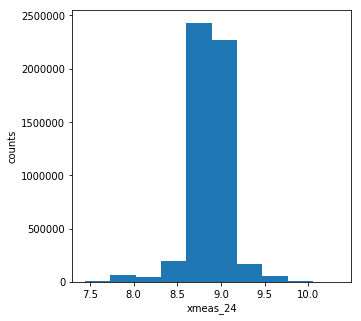

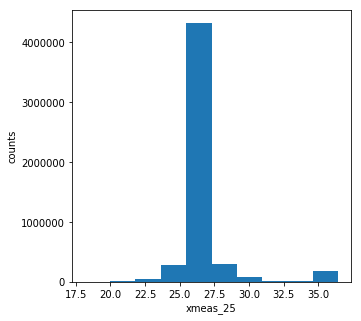

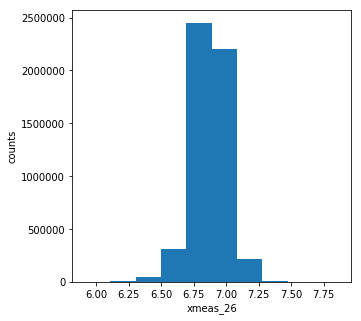

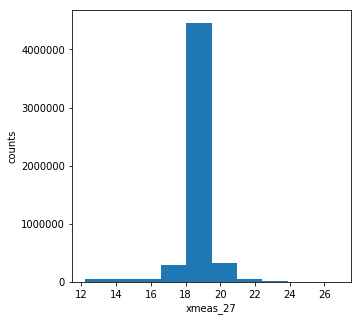

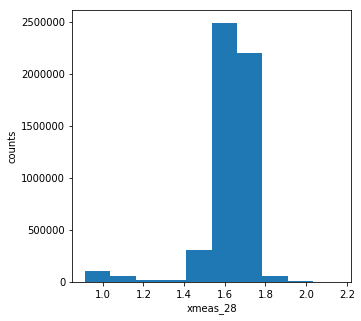

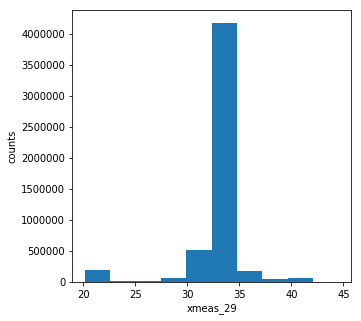

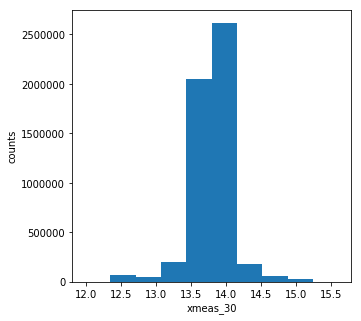

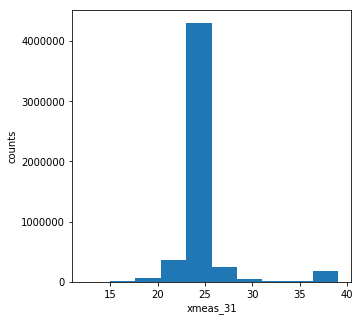

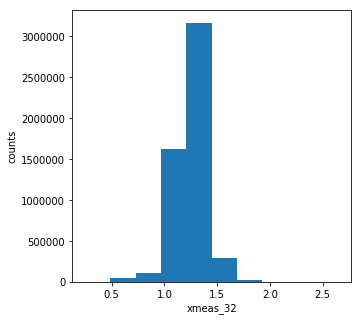

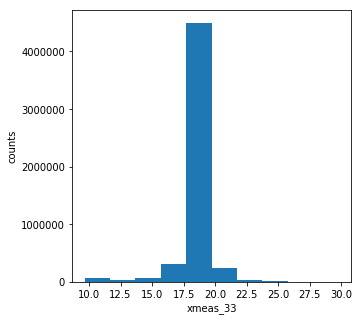

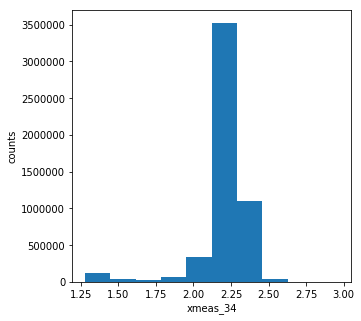

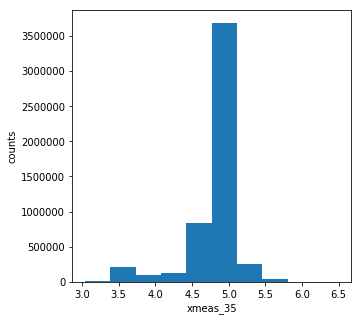

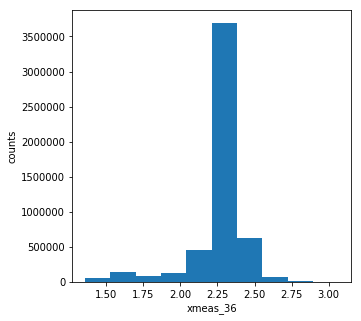

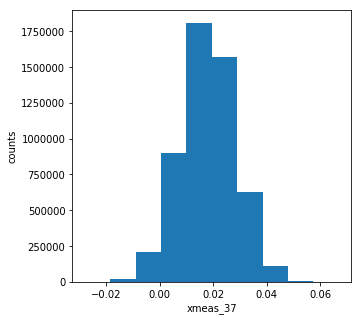

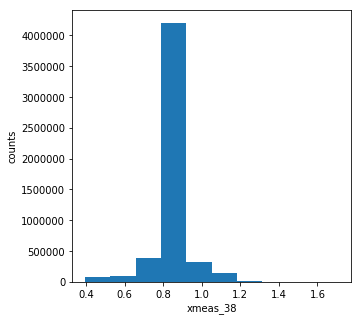

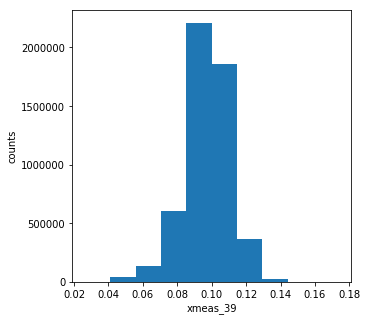

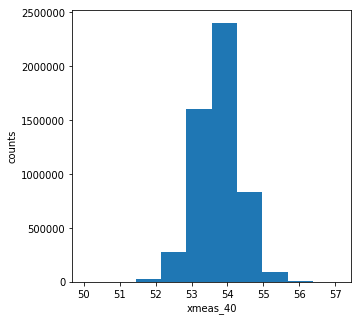

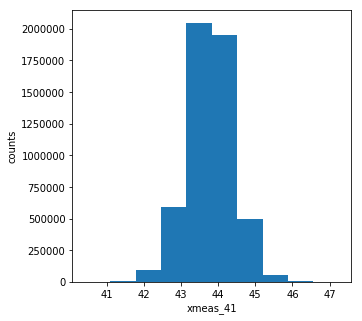

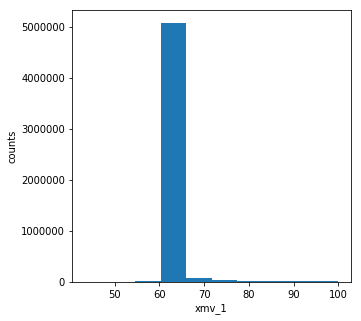

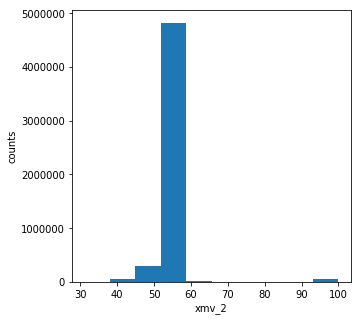

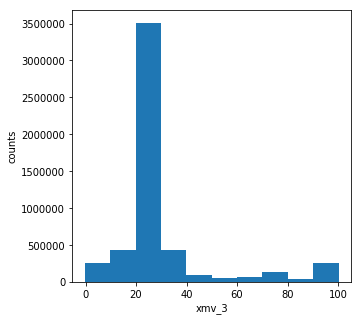

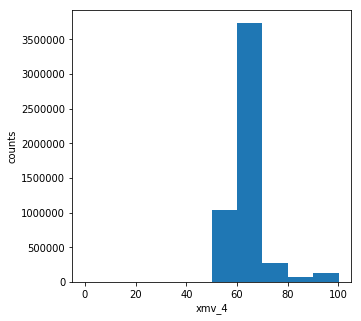

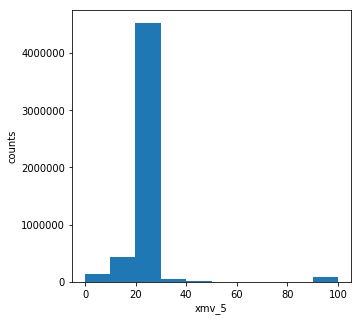

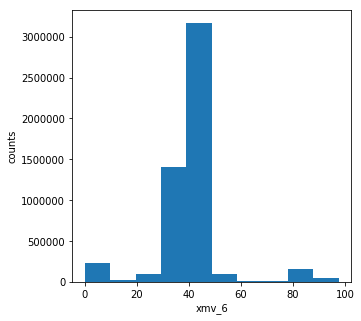

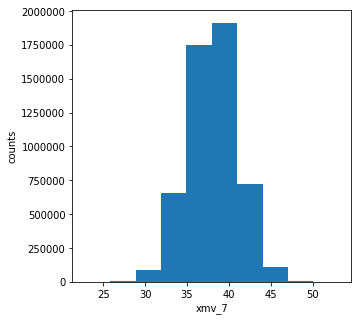

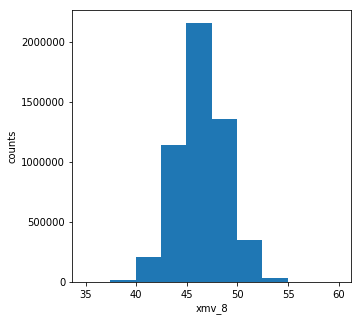

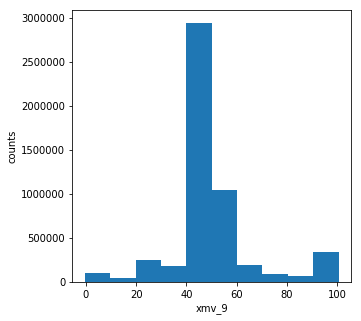

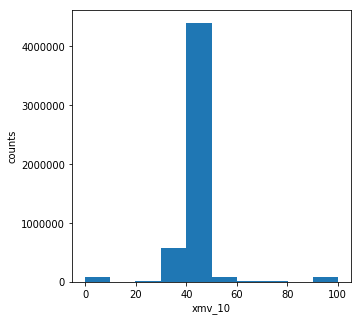

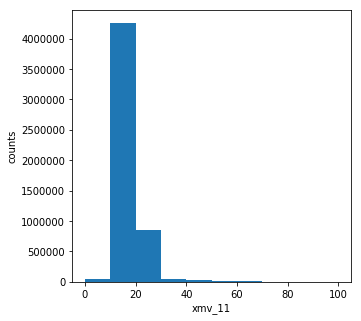

In [40]:
#Program to plot the histogram of the features in the train dataset
for col in columns_names[3:]:
    plt.figure(figsize=(5,5))
    #plt.subplot(26,2,i)
    plt.hist(train_ts[col])
    plt.xlabel(col)
    plt.ylabel('counts')
    plt.show()
    i += 1

# Observation:
- Most of the features are having almost a normal distrubution

# EDA of Test Data

In [10]:
test.describe()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
count,1.008000e+07,1.008000e+07,1.008000e+07,1.008000e+07,1.008000e+07,1.008000e+07,1.008000e+07,1.008000e+07,1.008000e+07,1.008000e+07,...,1.008000e+07,1.008000e+07,1.008000e+07,1.008000e+07,1.008000e+07,1.008000e+07,1.008000e+07,1.008000e+07,1.008000e+07,1.008000e+07
mean,1.000000e+01,2.505000e+02,4.805000e+02,2.562643e-01,3.665074e+03,4.510114e+03,9.387548e+00,2.690139e+01,4.237390e+01,2.724173e+03,...,5.470085e+01,2.912861e+01,6.362025e+01,2.323202e+01,3.929063e+01,3.804878e+01,4.642798e+01,4.956221e+01,4.199159e+01,1.934224e+01
std,6.055301e+00,1.443373e+02,2.771280e+02,1.381540e-01,4.296949e+01,1.060879e+02,3.725065e-01,2.267473e-01,3.180728e-01,7.742782e+01,...,7.455679e+00,1.904217e+01,8.682078e+00,1.245837e+01,1.287684e+01,2.938634e+00,2.342336e+00,1.710983e+01,1.159208e+01,8.681782e+00
min,0.000000e+00,1.000000e+00,1.000000e+00,-4.985500e-03,3.308400e+03,3.557100e+03,6.695700e+00,2.534800e+01,3.967900e+01,2.420200e+03,...,7.348400e+00,-3.586600e-01,-5.222600e-03,-1.068800e-01,0.000000e+00,2.228800e+01,3.336900e+01,-6.834200e-01,-5.156500e-01,-6.774200e-03
25%,5.000000e+00,1.257500e+02,2.407500e+02,2.198800e-01,3.637700e+03,4.473500e+03,9.273800e+00,2.676300e+01,4.219000e+01,2.698400e+03,...,5.355200e+01,2.223000e+01,6.036400e+01,2.155700e+01,3.840500e+01,3.600300e+01,4.485900e+01,4.544200e+01,4.062500e+01,1.711500e+01
50%,1.000000e+01,2.505000e+02,4.805000e+02,2.504200e-01,3.664000e+03,4.509400e+03,9.355700e+00,2.690000e+01,4.235000e+01,2.705400e+03,...,5.398200e+01,2.502700e+01,6.148400e+01,2.214400e+01,3.993400e+01,3.811100e+01,4.632800e+01,4.803600e+01,4.118500e+01,1.825400e+01
75%,1.500000e+01,3.752500e+02,7.202500e+02,2.795700e-01,3.690600e+03,4.546400e+03,9.447100e+00,2.704000e+01,4.252400e+01,2.713500e+03,...,5.442400e+01,2.813200e+01,6.274300e+01,2.267800e+01,4.134700e+01,3.996900e+01,4.801500e+01,5.130600e+01,4.182100e+01,1.946900e+01
max,2.000000e+01,5.000000e+02,9.600000e+02,1.016800e+00,3.891700e+03,5.164300e+03,1.223600e+01,2.856500e+01,4.455000e+01,3.000500e+03,...,1.000000e+02,1.002100e+02,1.000200e+02,1.000900e+02,9.724500e+01,5.423000e+01,6.021600e+01,1.005800e+02,1.006100e+02,1.000100e+02


# Histogram Plot of Test dataset

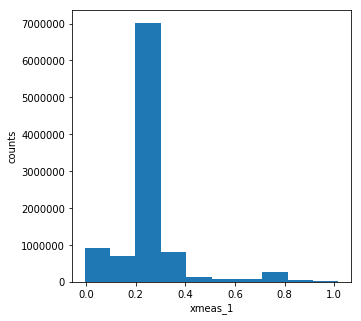

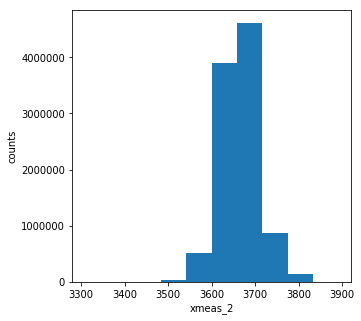

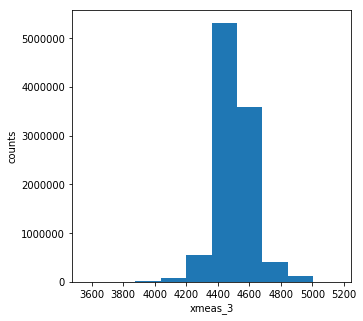

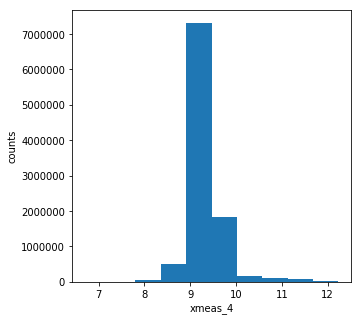

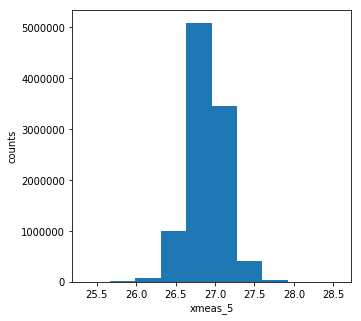

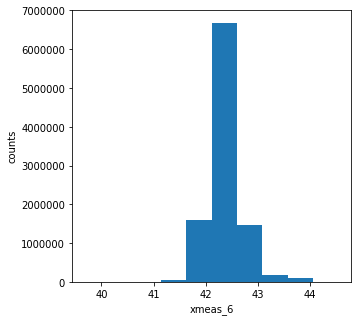

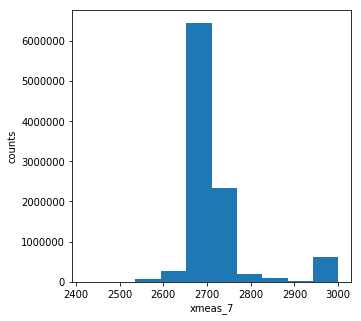

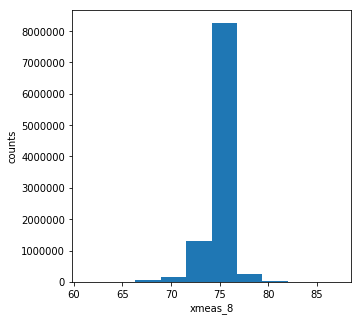

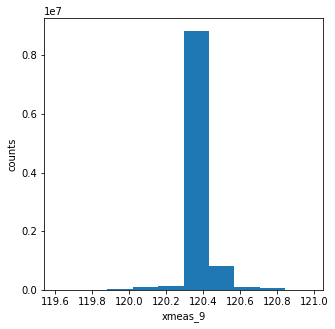

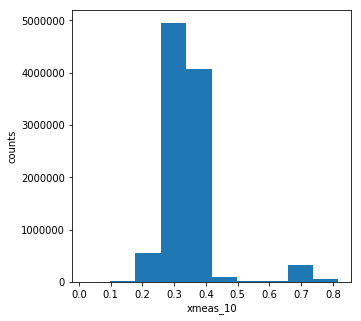

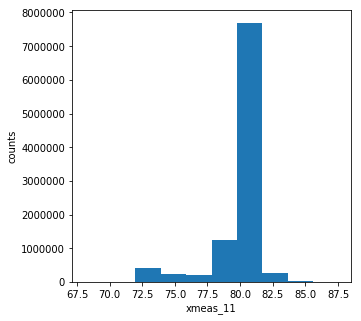

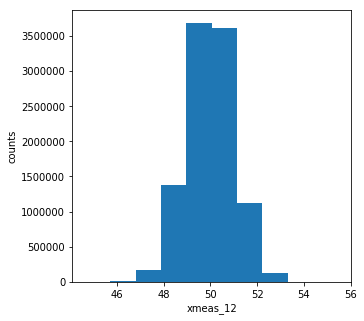

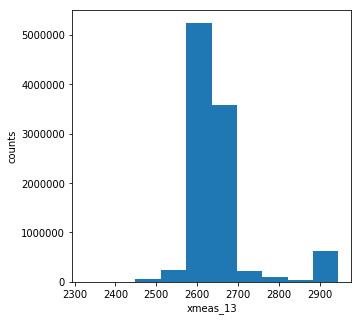

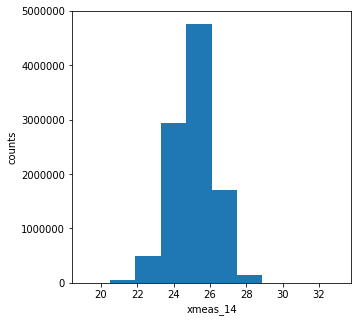

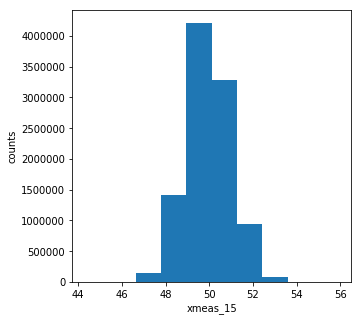

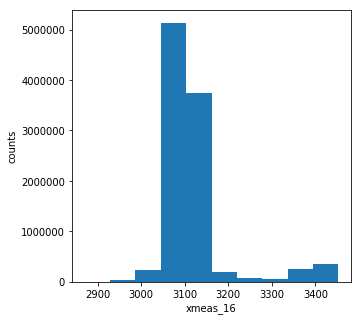

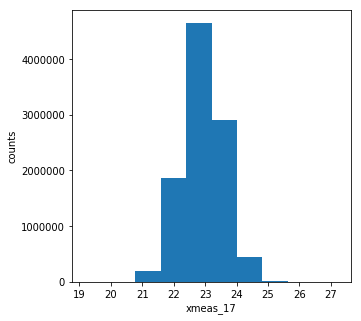

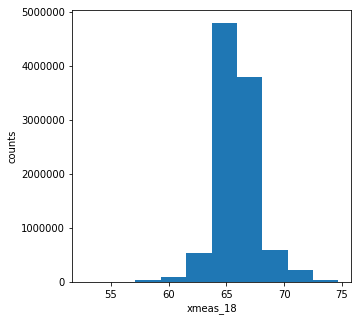

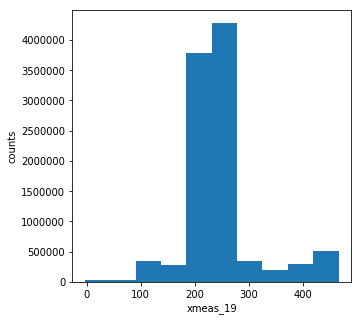

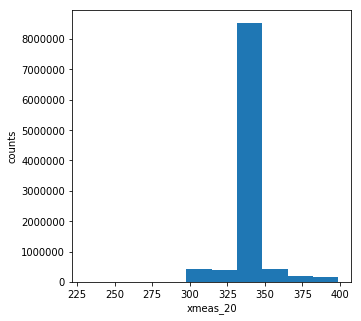

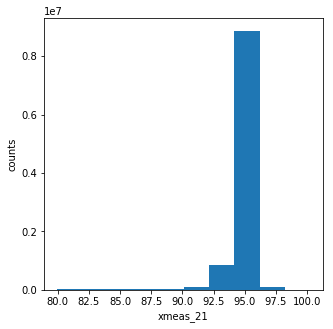

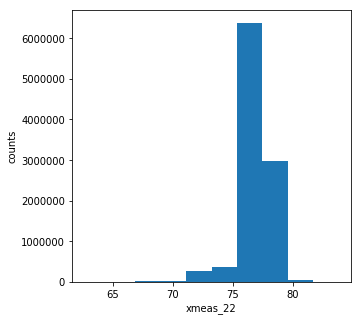

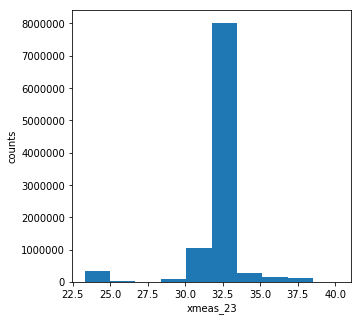

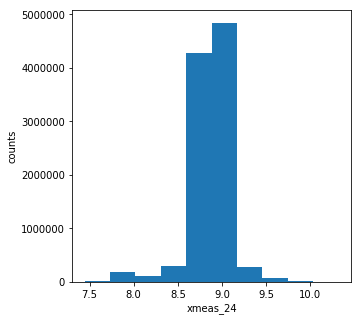

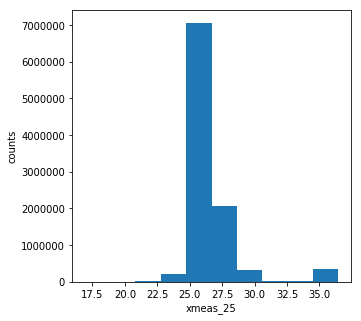

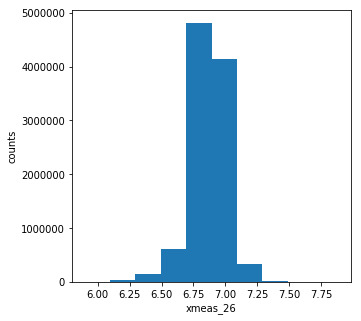

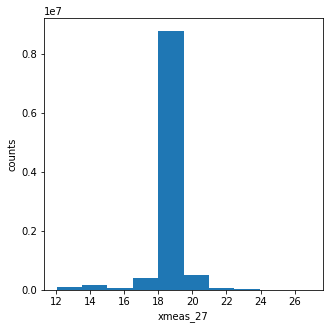

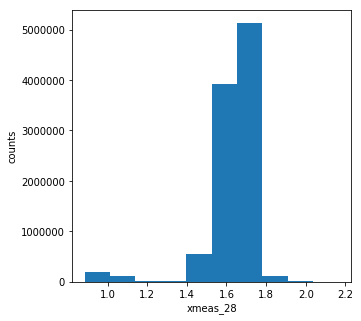

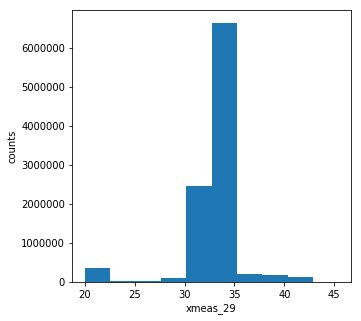

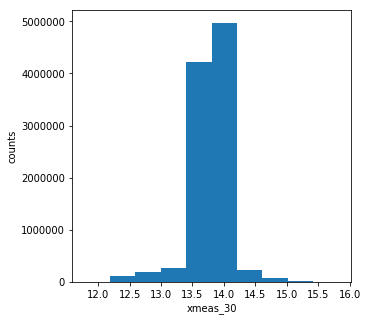

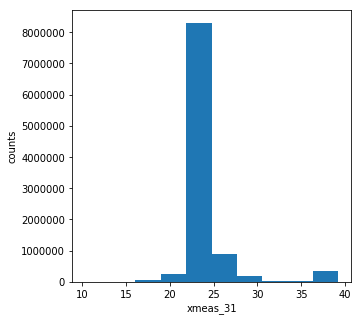

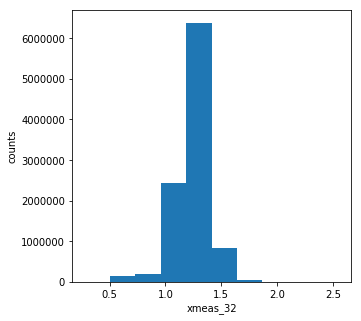

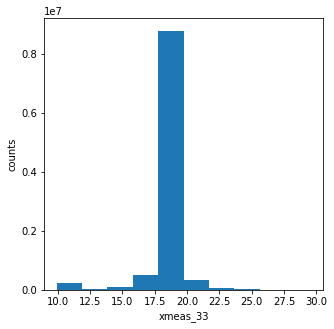

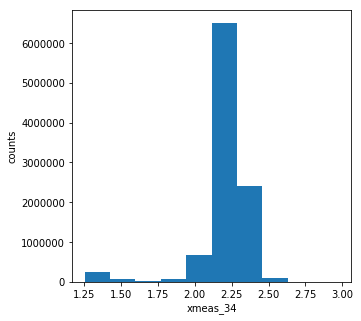

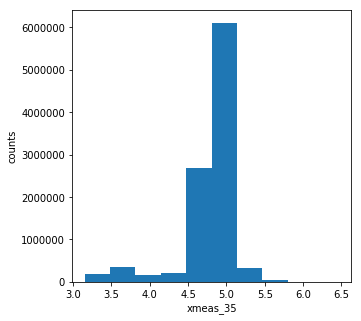

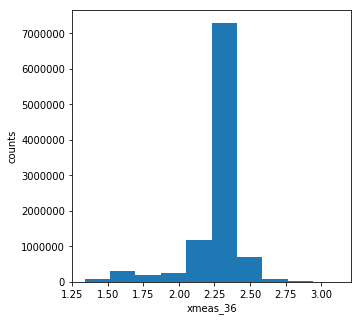

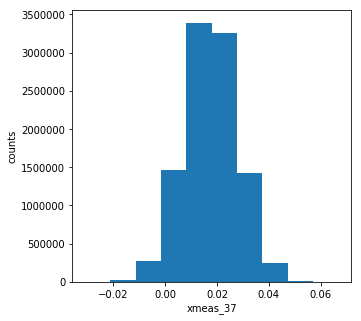

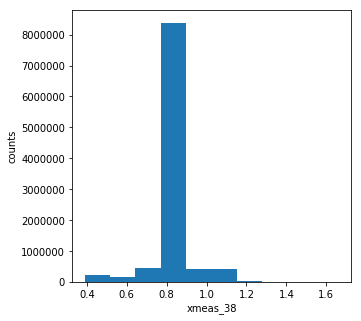

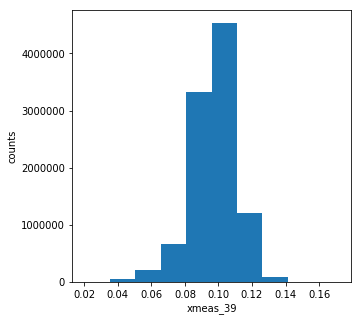

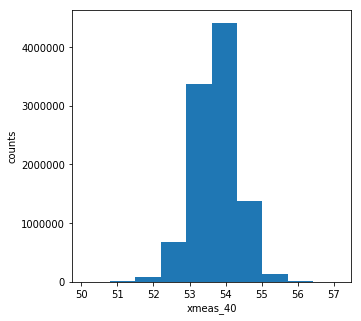

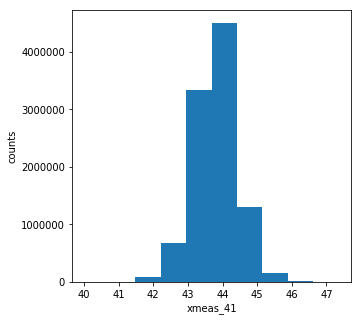

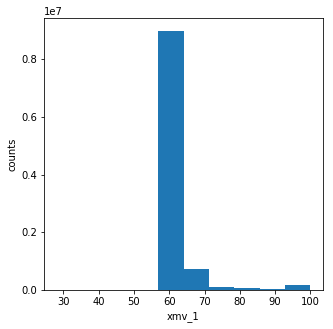

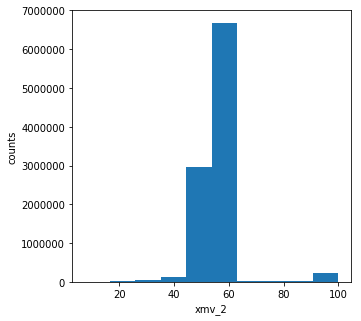

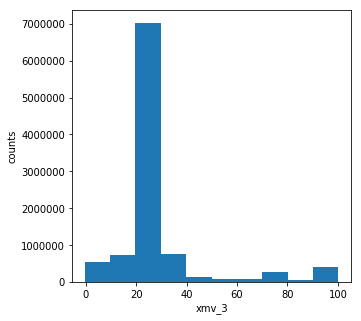

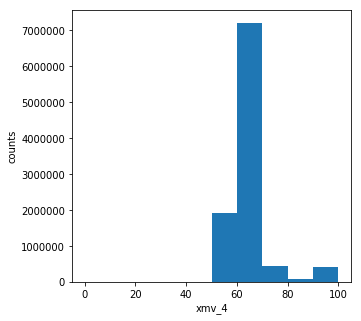

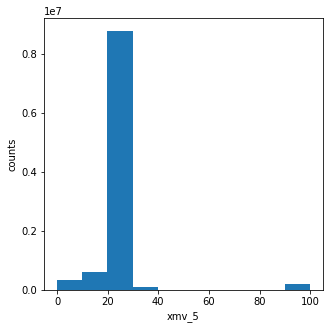

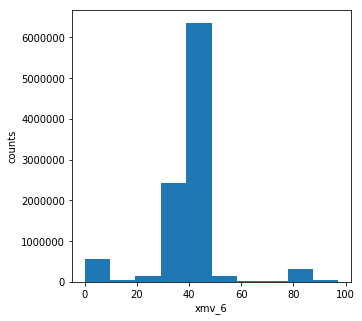

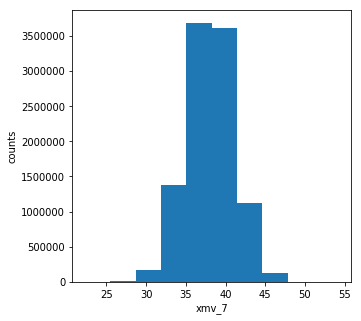

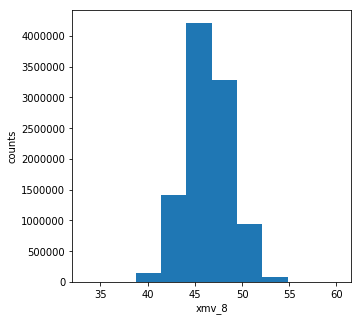

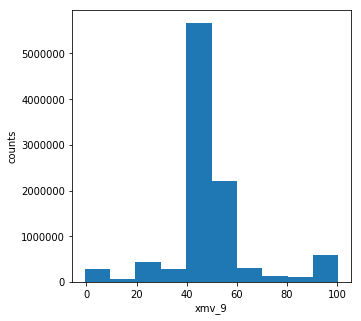

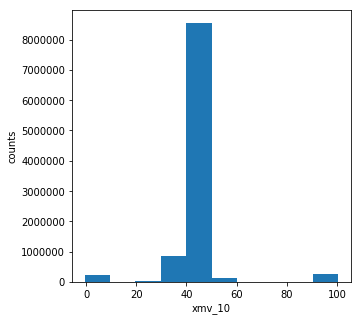

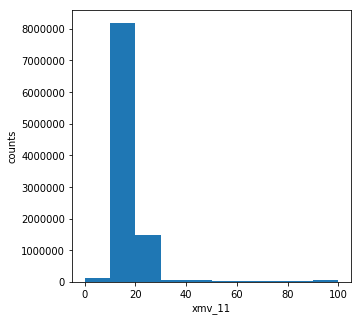

In [47]:
#Program to plot the histogram of the Test dataset
for col in col_names[3:]:
    plt.figure(figsize=(5,5))
    plt.hist(test[col])
    plt.xlabel(col)
    plt.ylabel("counts")
    plt.show()

# Data Preparation for Deep Learning Models:

- Inorder to reduce the training and test time complexity, we will sample the train and the test dataset. Since train and the test dataset, has 500 and 960 samples for each fault. To get the train and test dataset, the total number of simulation runs where 500 both for train and test. 
- Sampled Train, Sampled CV and Sampled Test is obtained in the following manner:
  - Sampled Train: 
       - For Fault Zero , i.e under normal operating condition, total samples taken 20000, i.e 40 simulation runs. 
       - For rest of the faults, for training data, fault is introduced after 1 hour of the simulation run, since each sample is sampled at 3mins, Sampled Train dataset is constructed by taking first 25 simulation runs and ignoring first 20 samples of each of the 25 simulations.
       
  - Sampled CV:
       -  For For Fault Zero , i.e under normal operating condition, total samples taken from 20000 - 30000, i.e 20 simulation runs from train dataset. 
       -  For rest of the faults, for training data, fault is introduced after 1 hour of the simulation run, since each sample is sampled at 3mins, Sampled CV dataset is constructed by taking  26 to 35 simulation runs and ignoring first 20 samples of each of the 9 simulations.
  - Sampled Test:
       - For For Fault Zero , i.e under normal operating condition, total samples taken from 2000, i.e 2 simulation runs from test dataset.
       - For rest of the faults, for test data, fault is introduced after 8 hour of the simulation run, since each sample is sampled at 3mins, Sampled test dataset is constructed by taking  first 10 simulation runs and ignoring first 160 samples of each of the 10 simulations.

In [14]:
Sampled_train = pd.DataFrame() # dataframe to store the train dataset
Sampled_test = pd.DataFrame() # dataframe to store test 
Sampled_cv = pd.DataFrame() # dataframe to store cv data
# Program to construct the sample train data
frame = []
for i in set(train_ts['faultNumber']): 
    b_i = pd.DataFrame()
    if i == 0:
        b_i = train_ts[train_ts['faultNumber'] == i][0:20000]
        frame.append(b_i)
    else:
        fr = []
        b = train_ts[train_ts['faultNumber'] == i]
        for x in range(1,25):
            b_x = b[b['simulationRun'] == x][20:500]
            fr.append(b_x)
        
        b_i = pd.concat(fr)
        
    frame.append(b_i)      
Sampled_train = pd.concat(frame)

# Program to construct the sample CV Data
frame = []
for i in set(train_ts['faultNumber']):
    b_i = pd.DataFrame()
    if i == 0:
        b_i = train_ts[train_ts['faultNumber'] == i][20000:30000]
        frame.append(b_i)
    else:
        fr = []
        b = train_ts[train_ts['faultNumber'] == i]
        for x in range(26,35):
            b_x = b[b['simulationRun'] == x][20:500]
            fr.append(b_x)
        
        b_i = pd.concat(fr)
        
    frame.append(b_i)      
Sampled_cv = pd.concat(frame)

# Program to construct Sampled Test data
frame = []
for i in set(test['faultNumber']):
    b_i = pd.DataFrame()
    if i == 0:
        b_i = test[test['faultNumber'] == i][0:2000]
        frame.append(b_i)
    else:
        fr = []
        b = test[test['faultNumber'] == i]
        for x in range(1,11):
            b_x = b[b['simulationRun'] == x][160:660]
            fr.append(b_x)
        
        b_i = pd.concat(fr)
        
    frame.append(b_i)      
Sampled_test = pd.concat(frame)

In [19]:
#Storing the Train, Test and CV dataset into csv file for further use.
Sampled_train.to_csv("train.csv")
Sampled_test.to_csv("test.csv")
Sampled_cv.to_csv("cv.csv")

In [11]:
train = pd.read_csv('train.csv')
cv = pd.read_csv("cv_new_1.csv")
test = pd.read_csv("test.csv")
train.head()

,Unnamed: 0,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [14]:
print("Shape of the sampled train data:", train.shape)
print("Shape of the sampled test data:", test.shape)
print("Shape of the sampled CV data:", cv.shape)

Shape of the sampled train data: (212000, 56)
Shape of the sampled test data: (104000, 56)
Shape of the sampled CV data: (106400, 56)


##### Refer TEP - models for Deep Learning models